<a href="https://colab.research.google.com/github/lmoroney/tfbook/blob/master/chapter11/climexp_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [55]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [56]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.9.1


In [57]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/tdaily_cet.dat.txt \
    -O /tmp/tdaily_cet.dat.txt

'wget' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


In [58]:
def get_data():
    data_file = "tdaily_cet.dat.txt"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(' ')
            temperatures.append(float(linedata[1]))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")
    return time, series



In [59]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [60]:
time, series = get_data()
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std
split_time = 80000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

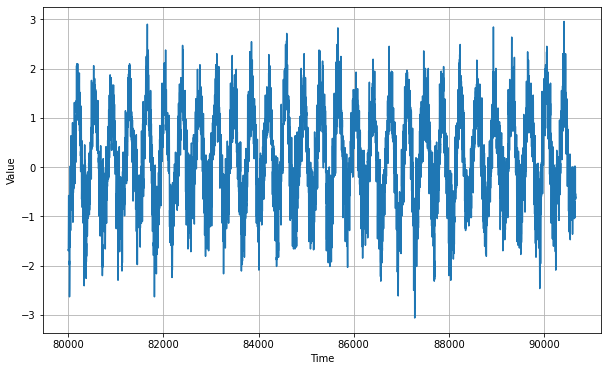

In [61]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [62]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [63]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 60
batch_size = 120
shuffle_buffer_size = 240

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True),
  tf.keras.layers.SimpleRNN(100), 
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=10,  verbose=1, validation_data=valid_dataset)

Epoch 1/10


C:\Users\camjt\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


667/667 [==============================] - 28s 40ms/step - loss: 0.1870 - mae: 0.4799 - val_loss: 0.0929 - val_mae: 0.3424
Epoch 2/10
667/667 [==============================] - 27s 41ms/step - loss: 0.0885 - mae: 0.3328 - val_loss: 0.0732 - val_mae: 0.3034
Epoch 3/10
667/667 [==============================] - 26s 39ms/step - loss: 0.0760 - mae: 0.3076 - val_loss: 0.0656 - val_mae: 0.2874
Epoch 4/10
667/667 [==============================] - 26s 39ms/step - loss: 0.0702 - mae: 0.2954 - val_loss: 0.0615 - val_mae: 0.2782
Epoch 5/10
667/667 [==============================] - 26s 39ms/step - loss: 0.0668 - mae: 0.2879 - val_loss: 0.0587 - val_mae: 0.2717
Epoch 6/10
667/667 [==============================] - 28s 42ms/step - loss: 0.0645 - mae: 0.2827 - val_loss: 0.0567 - val_mae: 0.2670
Epoch 7/10
667/667 [==============================] - 29s 43ms/step - loss: 0.0628 - mae: 0.2787 - val_loss: 0.0552 - val_mae: 0.2633
Epoch 8/10
667/667 [==============================] - 27s 40ms/step - los

In [64]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [65]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

334/334 [==============================] - 3s 9ms/step


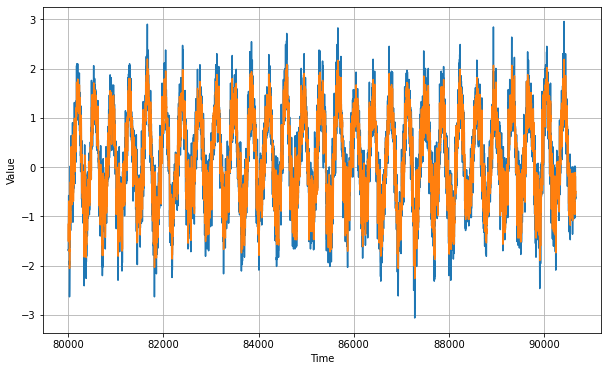

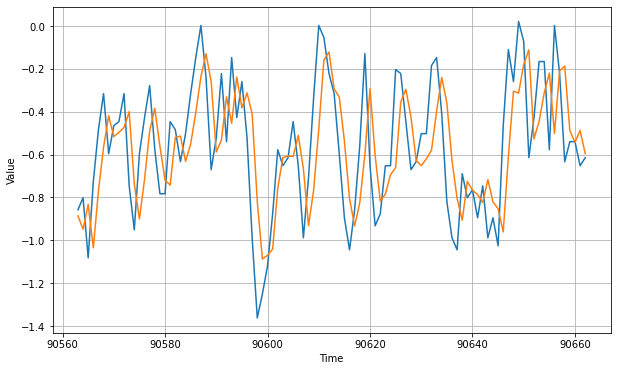

In [66]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()


In [67]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(mae)

0.25617677


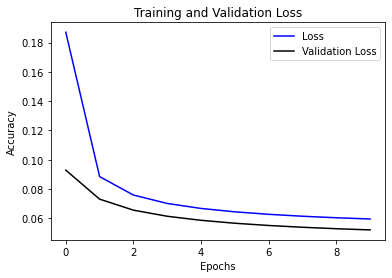

<Figure size 432x288 with 0 Axes>

In [68]:
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()
